## source: https://thekalmanfilter.com/kalman-filter-python-example/

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## Compute Measurements
In order to build and test a Kalman Filter, a set of input data is needed. For this example, the get_measure(…) function is used to simulate a sensor providing real-time position measurements of a performance automobile as it races down a flat road with a constant velocity of 60 meters per second.

This function initializes the position at 0 and velocity at 60 meters per second. Next, random noise, v, is computed and added to position measurement. Additional random noise, w, is computed and added to the velocity to account for small random accelerations. Lastly, the current position and current velocity are retained as truth data for the next measurement step.

In [12]:
def get_measure(updateNumber):
    if updateNumber == 1:
        get_measure.cur_pos = 0
        get_measure.cur_vel = 60 # m/s
    dt = 0.1
    w = 8 * np.random.randn(1)
    v = 8 * np.random.randn(1)
    z = get_measure.cur_pos + get_measure.cur_vel*dt + v
    get_measure.cur_pos = z - v
    get_measure.cur_vel = 60 + w
    return [z, get_measure.cur_pos, get_measure.cur_vel]

## Filter Measurements
Now that you have input measurements to process with your filter, its time to code up your python Kalman Filter. The code for this example is consolidated into one function.

When the first measurement is reported, the filter is initialized. The measurement is in the following structures. z is the position measurement, R is the position variance, and t is the timestamp of the measurement.

![](images/position_measurement_equations-1024x132.png)

x is the two element state vector for position and velocity. P is the 2×2 state covariance matrix representing the uncertainty in x. T is the timestamp for the estimate.

![](images/position_velocity_state_equations-1024x156.png)

A is the state transition matrix for a system model that assumes constant linear motion. H is the state to measurement transition matrix. HT is the H matrix transposed. R is the input measurement variance. Q is the 2×2 system noise covariance matrix. Q accounts for inaccuracy in the system model (for example car is not going where it is supposed to be going).

![](images/kalman_filter_system_model_equations-1024x149.png)

All measurements, after the first one, are filtered into the track state. First, the predicted state, xP, and predicted state covariance, PP, are computed by propagating the existing state and state covariance in time to align with the new measurements.
![](images/predicted_state_equations-1024x156.png)
![](images/predicted_state_covariance_equations-1024x280.png)

For this example, it is assumed that measurements have a 10/second and therefore a delta time, dt, of 0.1 seconds is used. Next the Kalman Gain, K, is computed using the input measurement uncertainty, R, and the predicted state covariance matrix, PP. This computation was broken down into two steps, first compute the innovation, S, and then compute the Kalman Gain, K, with the innovation.
![](images/innovation_equations-1024x310.png)
![](images/kalman_gain_equation-1024x131.png)

Lastly, the Kalman Gain, K, is used to compute the new state, x, and state covariance estimate, P.
![](images/estimate_state_and_covariance_equations-1024x152.png)

In [18]:
def filt(z, updateNumber):
    dt = 0.1
    # Initialize State
    if updateNumber == 1:
        filt.x = np.array([[0],
                           [20]])
        filt.P = np.array([[5, 0],
                           [0, 5]])
        filt.A = np.array([[1, dt],
                           [0, 1]])
        filt.H = np.array([[1, 0]])
        filt.HT = np.array([[1],
                            [0]])
        filt.R = 10
        filt.Q = np.array([[1, 0],
                           [0, 3]])
    # Predict State Forward
    x_p = filt.A@filt.x
    # Predict Covariance Forward
    P_p = filt.A@filt.P@filt.A.T + filt.Q
    # Compute Kalman Gain
    S = filt.H@P_p@filt.HT + filt.R
    K = P_p@filt.HT*(1/S)
    # Estimate State
    residual = z - filt.H@x_p
    filt.x = x_p + K*residual
    # Estimate Covariance
    filt.P = P_p - K@filt.H@P_p
    return [filt.x[0], filt.x[1], filt.P];

## Test Kalman Filter
Now that you have both the input measurements to process and your Kalman Filter, its time to write a test program so that you see how your filter performs.

In [19]:
def testFilter():
    dt = 0.1
    t = np.linspace(0, 10, num=300)
    numOfMeasurements = len(t)
    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []
    for k in range(1, numOfMeasurements):
        z = get_measure(k)
        # Call Filter and return new State
        f = filt(z[0], k)
        # Save off that state so that it could be plotted
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))
    return [measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma];

## Plot Kalman Filter Results
The first plot below shows the position measurement error and estimate error relative to the actual position of the vehicle. This plot shows how the Kalman Filter smooths the input measurements and reduces the positional error.

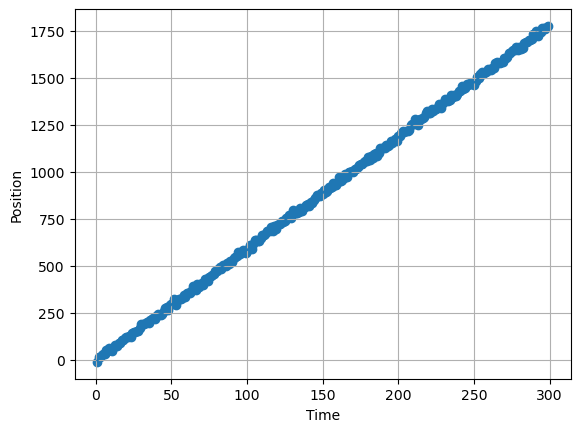

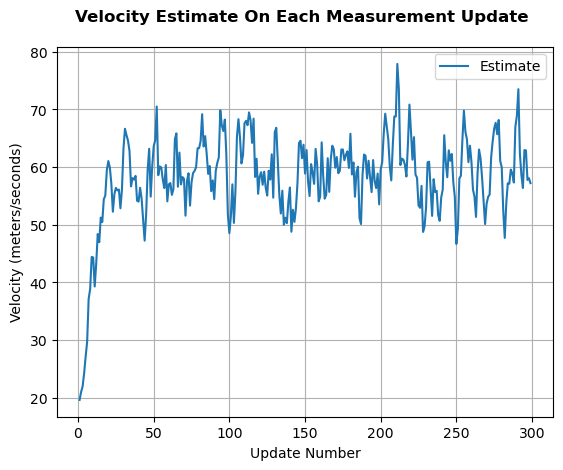

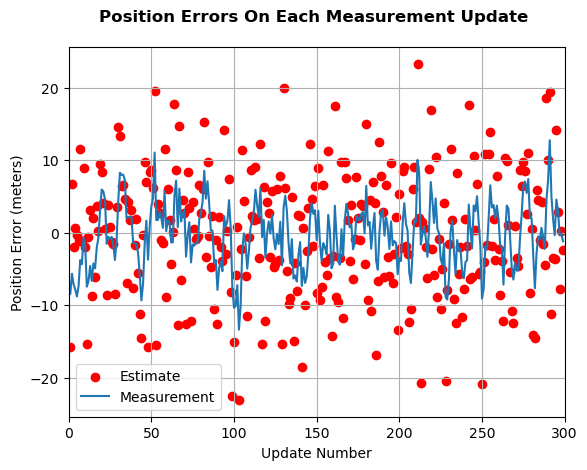

In [20]:
t = testFilter()
plot1 = plt.figure(1)
plt.scatter(t[0], t[1])
plt.plot(t[0], t[2])
plt.ylabel('Position')
plt.xlabel('Time')
plt.grid(True)
plot2 = plt.figure(2)
plt.plot(t[0], t[3])
plt.ylabel('Velocity (meters/seconds)')
plt.xlabel('Update Number')
plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
plt.legend(['Estimate'])
plt.grid(True)
plot3 = plt.figure(3)
plt.scatter(t[0], t[4], color = 'red')
plt.plot(t[0], t[5])
plt.legend(['Estimate', 'Measurement'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()

The first plot below shows the position measurement error and estimate error relative to the actual position of the vehicle. This plot shows how the Kalman Filter smooths the input measurements and reduces the positional error.


The second plot shows the velocity estimate for the vehicle based on the input measurements. It can be seen that after the first five or so measurements the filter starts to settle on the vehicles actual speed which is 60 meters per second.

More materials: https://www.kalmanfilter.net/kalman1d.html and http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies